# 互评作业2: 频繁模式与关联规则挖掘。

### 数据集说明
采用的数据集：Wine Reviews，数据文件：winemag-data_first150k.csv
数据集共有10个特征，分别为country：葡萄酒的生产国；description：葡萄酒的描述性文本；designation:用来制作葡萄酒的葡萄的产地；points：葡萄酒的评分（满分100，所有评分都大于等于80）；price：葡萄酒的价格（美元）；region_1：葡萄酒生产的具体的州或者省；region_2:比region_1更细致的地址；variety：葡萄的种类；winery：酿酒厂

In [30]:
import pandas as pd

In [5]:
df = pd.read_csv('winemag-data_first150k.csv',index_col=0)
df.head(5)

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [6]:
df.describe()

,points,price
count,150930.000000,137235.000000
mean,87.888418,33.131482
std,3.222392,36.322536
min,80.000000,4.000000
25%,86.000000,16.000000
50%,88.000000,24.000000
75%,90.000000,40.000000
max,100.000000,2300.000000


# 数据预处理
### points与price特征的处理
由于关联规则挖掘一般是对于类别型变量进行的，而points和price为连续性变量，我们对其进行处理，将这两个变量转换为只有两个类别的类别型变量。我们设定price>40的为高价格(high_price)，price<=40为低价格(low_price)，而points>88.0定义为高分数(high_points)，points<=88.0定义为低分数（low_points）。  
处理过程如下所示：

将数据集中的连续特征price和points改为类别变量，根据这两个变量的数值分布情况，规定价格在40美元以上的为高价格，40美元以下的为低价格  
规定分数在88分以上的就为高评分，88分以下为低评分

In [7]:
df['high_price'] = df['price'].apply(lambda x:1 if x > 40 else 0 )
df['low_price'] = df['price'].apply(lambda x: 1 if x <= 40 else 0)

In [8]:
df['high_points'] = df['points'].apply(lambda x:1 if x > 88.0 else 0 )
df['low_points'] = df['points'].apply(lambda x:1 if x <= 88.0 else 0 )

In [9]:
df.head(5)

,country,description,designation,points,price,province,region_1,region_2,variety,winery,high_price,low_price,high_points,low_points
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,1,0,1,0
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez,1,0,1,0
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,1,0,1,0
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,1,0,1,0
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude,1,0,1,0


### country特征的处理
还有一个可用的类别型变量为country，但是country特征的取值过多，我们对这一变量进行进一步的简化，将country变量映射为continents变量，为其生产国所属的大洲，分别有北美洲，南美洲，欧洲，亚洲，非洲，大洋洲。  
  
下面列出了数据集中所有生产国信息：

In [10]:
df['country'].value_counts()

US                        62397
Italy                     23478
France                    21098
Spain                      8268
Chile                      5816
Argentina                  5631
Portugal                   5322
Australia                  4957
New Zealand                3320
Austria                    3057
Germany                    2452
South Africa               2258
Greece                      884
Israel                      630
Hungary                     231
Canada                      196
Romania                     139
Slovenia                     94
Uruguay                      92
Croatia                      89
Bulgaria                     77
Moldova                      71
Mexico                       63
Turkey                       52
Georgia                      43
Lebanon                      37
Cyprus                       31
Brazil                       25
Macedonia                    16
Serbia                       14
Morocco                      12
England 

将国家信息与大洲信息对应起来

In [11]:
def continents(data):
    North_America = ['US', 'Canada']
    South_America = ['Chile', 'Argentina','Uruguay','Mexico','Turkey','Brazil']
    Europe = ['Italy', 'Spain', 'France', 'Portugal','Austria', 'Germany','Greece','Hungary','Romania',
              'Slovenia','Ukraine','Bosnia and Herzegovina','Croatia','Bulgaria','Moldova','Georgia',
              'Macedonia','Serbia','Morocco','Luxembourg','England','Lithuania','Czech Republic','Switzerland ',
              'Slovakia','Montenegro','Albania','US-France']
    Africa = ['South Africa','Egypt','Tunisia']
    Asia = ['Israel','Lebanon','Cyprus','India','South Korea', 'China', 'Japan']
    Oceania = ['Australia', 'New Zealand']
    if data in North_America:
        return 'North_America'
    elif data in South_America:
        return 'South_America'
    elif data in Europe:
        return 'Europe'
    elif data in Africa:
        return 'Africa'
    elif data in Asia:
        return 'Asia'
    else:
        return 'Oceainia'

df['continents'] = df['country'].apply(continents)

In [12]:
new_df = df['continents']

In [15]:
new_df[:10]

0    North_America
1           Europe
2    North_America
3    North_America
4           Europe
5           Europe
6           Europe
7           Europe
8    North_America
9    North_America
Name: continents, dtype: object

下面再对大洲特征进行one-hot编码

In [31]:
new_df = pd.get_dummies(new_df)

再将大洲信息与评分和价格信息拼成一个最终完整的数据集

In [32]:
new_df['high_price'] = df['high_price']
new_df['low_price'] = df['low_price']
new_df['high_points'] = df['high_points']
new_df['low_points'] = df['low_points']

最终我们得到了最终用来对关联规则进行挖掘的数据集：

In [33]:
new_df.head(10)

,Africa,Asia,Europe,North_America,Oceainia,South_America,high_price,low_price,high_points,low_points
0,0,0,0,1,0,0,1,0,1,0
1,0,0,1,0,0,0,1,0,1,0
2,0,0,0,1,0,0,1,0,1,0
3,0,0,0,1,0,0,1,0,1,0
4,0,0,1,0,0,0,1,0,1,0
5,0,0,1,0,0,0,1,0,1,0
6,0,0,1,0,0,0,1,0,1,0
7,0,0,1,0,0,0,1,0,1,0
8,0,0,0,1,0,0,1,0,1,0
9,0,0,0,1,0,0,1,0,1,0


最后我们将二值矩阵转换成事务型的列表数据。这里只列出了前7条。  
**[['North_America', 'high_price', 'high_points'],  
['Europe', 'high_price', 'high_points'],  
['North_America', 'high_price', 'high_points'],  
['North_America', 'high_price', 'high_points'],  
['Europe', 'high_price', 'high_points'],  
['Europe', 'high_price', 'high_points'],  
['Europe', 'high_price', 'high_points']]**

# 关联规则挖掘过程
## 算法步骤：
Apriori算法过程如下：  
生成1项集：单趟扫描数据库D计算出各个1项集的支持度，得到频繁1项集的集合。    
连接：由k-1项集生成k项集。k-1项集中只有前k-2个项（按字典排序）相同的项，才可以进行连接。  
剪枝：由于连接得到的项集中某些元素不是频繁的，所以需要进行剪枝操作，剔除那些在候选集中的非频繁项集。通过单趟扫描数据集，计算中候选集中各个项集的支持度，将其中小于最小支持度的项集去掉，得到k项频繁项集。  
重复步骤2～4，直到得到最终要求的k项集（k为人工输入），这时算法停止。在剪枝步中的每个元素需在数据集中进行验证来决定其支持度是否满足最大支持度，这里的验证过程需要对数据集进行多次扫描，是Apriori算法性能的一个瓶颈。
### 支持度
支持度(support)=(X,Y).count/T.count, (T是事务总和，(X,Y).count是X、Y同时出现的次数)
### 置信度
置信度(confidence)=(X,Y).count/X.count
### 期望置信度
期望置信度=Y.count/T.count
### lift提升度
提升度是可信度与期望可信度的比值，提升度大于1表示正相关，小于1表示负相关，等于1表示不相关。lift评价可以弥补置信度、支持度自身的不足，使得评价更为合理。利用这个值可以对关键规则进行排序，在一定程度上也是一个规则优化挑选的过程。




# Apriori算法代码

In [13]:
def getTransaction(full_item, bool_item):
    ret = []
    for i in range(len(full_item)):
        if bool_item[i]==1:
            ret.append(full_item[i])
    return ret

def preProcess():
    ret = []
    attr = list(new_df.columns.values)
    for i in range(len(new_df)):
        trans = getTransaction(attr, new_df.loc[i])
        ret.append(trans)
    return ret

In [14]:
def create_C1(data_set):
    """
    Create frequent candidate 1-itemset C1 by scaning data set.
    Args:
        data_set: A list of transactions. Each transaction contains several items.
    Returns:
        C1: A set which contains all frequent candidate 1-itemsets
    """
    C1 = set()
    for t in data_set:
        for item in t:
            item_set = frozenset([item])
            C1.add(item_set)
    return C1


def is_apriori(Ck_item, Lksub1):
    """
    Judge whether a frequent candidate k-itemset satisfy Apriori property.
    Args:
        Ck_item: a frequent candidate k-itemset in Ck which contains all frequent
                 candidate k-itemsets.
        Lksub1: Lk-1, a set which contains all frequent candidate (k-1)-itemsets.
    Returns:
        True: satisfying Apriori property.
        False: Not satisfying Apriori property.
    """
    for item in Ck_item:
        sub_Ck = Ck_item - frozenset([item])
        if sub_Ck not in Lksub1:
            return False
    return True


def create_Ck(Lksub1, k):
    """
    Create Ck, a set which contains all all frequent candidate k-itemsets
    by Lk-1's own connection operation.
    Args:
        Lksub1: Lk-1, a set which contains all frequent candidate (k-1)-itemsets.
        k: the item number of a frequent itemset.
    Return:
        Ck: a set which contains all all frequent candidate k-itemsets.
    """
    Ck = set()
    len_Lksub1 = len(Lksub1)
    list_Lksub1 = list(Lksub1)
    for i in range(len_Lksub1):
        for j in range(1, len_Lksub1):
            l1 = list(list_Lksub1[i])
            l2 = list(list_Lksub1[j])
            l1.sort()
            l2.sort()
            if l1[0:k-2] == l2[0:k-2]:
                Ck_item = list_Lksub1[i] | list_Lksub1[j]
                # pruning
                if is_apriori(Ck_item, Lksub1):
                    Ck.add(Ck_item)
    return Ck


def generate_Lk_by_Ck(data_set, Ck, min_support, support_data):
    """
    Generate Lk by executing a delete policy from Ck.
    Args:
        data_set: A list of transactions. Each transaction contains several items.
        Ck: A set which contains all all frequent candidate k-itemsets.
        min_support: The minimum support.
        support_data: A dictionary. The key is frequent itemset and the value is support.
    Returns:
        Lk: A set which contains all all frequent k-itemsets.
    """
    Lk = set()
    item_count = {}
    for t in data_set:
        for item in Ck:
            if item.issubset(t):
                if item not in item_count:
                    item_count[item] = 1
                else:
                    item_count[item] += 1
    t_num = float(len(data_set))
    for item in item_count:
        if (item_count[item] / t_num) >= min_support:
            Lk.add(item)
            support_data[item] = item_count[item] / t_num
    return Lk


def generate_L(data_set, k, min_support):
    """
    Generate all frequent itemsets.
    Args:
        data_set: A list of transactions. Each transaction contains several items.
        k: Maximum number of items for all frequent itemsets.
        min_support: The minimum support.
    Returns:
        L: The list of Lk.
        support_data: A dictionary. The key is frequent itemset and the value is support.
    """
    support_data = {}
    C1 = create_C1(data_set)
    L1 = generate_Lk_by_Ck(data_set, C1, min_support, support_data)
    Lksub1 = L1.copy()
    L = []
    L.append(Lksub1)
    for i in range(2, k+1):
        Ci = create_Ck(Lksub1, i)
        Li = generate_Lk_by_Ck(data_set, Ci, min_support, support_data)
        Lksub1 = Li.copy()
        L.append(Lksub1)
    return L, support_data


def generate_big_rules(L, support_data, min_conf, min_support):
    """
    Generate big rules from frequent itemsets.
    Args:
        L: The list of Lk.
        support_data: A dictionary. The key is frequent itemset and the value is support.
        min_conf: Minimal confidence.
    Returns:
        big_rule_list: A list which contains all big rules. Each big rule is represented
                       as a 3-tuple.
    """
    big_rule_list = []
    sub_set_list = []
    for i in range(0, len(L)):
    #i -> i# 项集
        for freq_set in L[i]:
            #freq_set -> i项集中的每个元素
            for sub_set in sub_set_list:
                if sub_set.issubset(freq_set):
                    conf = support_data[freq_set] / support_data[freq_set - sub_set]
                    sup = support_data[freq_set]
                    lift = conf / support_data[sub_set]
                    big_rule = (freq_set - sub_set, sub_set, conf, sup, lift)
                    if conf >= min_conf and sup >= min_support and big_rule not in big_rule_list:
                        # print freq_set-sub_set, " => ", sub_set, "conf: ", conf
                        big_rule_list.append(big_rule)
            # l1中的每个元素都在其中
            sub_set_list.append(freq_set)
    return big_rule_list
import matplotlib.pyplot as plt

def plot_bar(rules, data, title):
    plt.title(title)
    plt.xticks(range(len(data)),rules,rotation=90)
    plt.bar(range(len(data)), data, color = 'B')
    plt.show()

def visualization(big_rule_list):
    rules = []
    conf = []
    support = []
    lift = []
    for i in range(len(big_rule_list)):
        rule = "{}=>{}".format(list(big_rules_list[i][0]), list(big_rules_list[i][1]))
        rules.append(rule)
        conf.append(big_rule_list[i][2])
        support.append(big_rule_list[i][3])
        lift.append(big_rule_list[i][4])
    plot_bar(rules, support, 'rule-support figure')
    plot_bar(rules, conf, 'rule-confidence figure')
    plot_bar(rules, lift, 'rule-lift figure')

In [15]:
data_set = preProcess()

frequent 1-itemsets		support
frozenset({'low_price'}) 0.7017690320015901
frozenset({'low_points'}) 0.5949711786921089
frozenset({'high_price'}) 0.20749354005167958
frozenset({'North_America'}) 0.41471543099450076
frozenset({'Europe'}) 0.4332737030411449
frozenset({'high_points'}) 0.4050288213078911
frequent 2-itemsets		support
frozenset({'high_points', 'high_price'}) 0.16014046246604385
frozenset({'North_America', 'high_price'}) 0.10329291724640562
frozenset({'low_price', 'Europe'}) 0.25900086132644273
frozenset({'low_price', 'North_America'}) 0.30969986086265155
frozenset({'low_points', 'North_America'}) 0.24806201550387597
frozenset({'low_points', 'Europe'}) 0.23858742463393626
frozenset({'high_points', 'Europe'}) 0.19468627840720865
frozenset({'low_price', 'low_points'}) 0.5040681110448553
frozenset({'low_price', 'high_points'}) 0.19770092095673492
frozenset({'North_America', 'high_points'}) 0.1666534154906248
frequent 3-itemsets		support
frozenset({'low_price', 'Europe', 'low_point

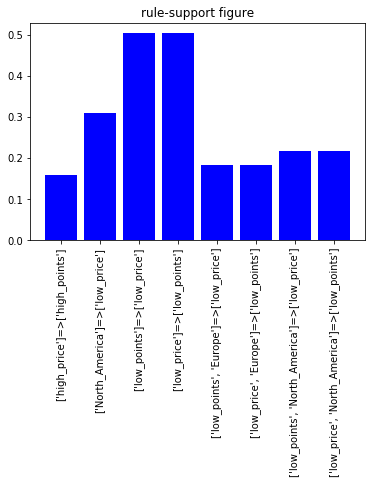

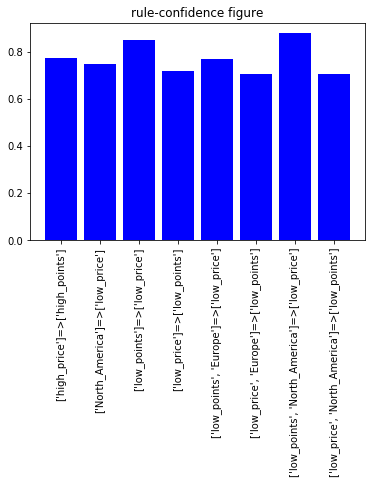

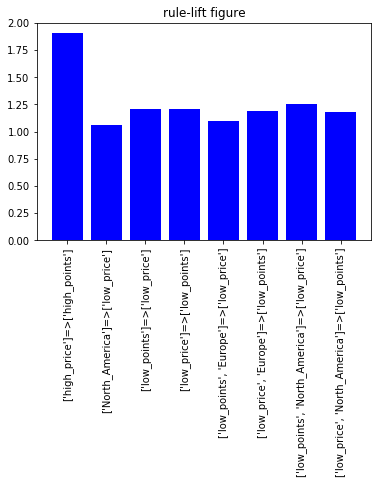

In [16]:
L, support_data = generate_L(data_set, k=3, min_support=0.1)
#big_rules_list是一个列表，列表的元素是元组->(规则条件，规则结果，置信度)
big_rules_list = generate_big_rules(L, support_data, min_conf=0.7, min_support=0.1)
# L is a list with sets element,
for Lk in L:
    print ("="*50)
    print ("frequent " + str(len(list(Lk)[0])) + "-itemsets\t\tsupport")
    print ("="*50)
    for freq_set in Lk:
        print (freq_set, support_data[freq_set])
print()
print ("Big Rules is: ")
print('=' * 50)
for item in big_rules_list:
    print("{}=>{}, confidence: {:.2f}, support: {:.2f}, lift: {:.3f}".format(list(item[0]), list(item[1]), item[2], item[3], item[4]))
visualization(big_rules_list)

我们令k=3，最小置信度为0.7，最小支持度为0.1，得到的1~3项集以及强关联规则还有各规则的支持度、置信度、提升度的可视化都在上面展示了出来。  

# 最终结果
最终我们得到的强关联规则为：  
**['North_America']=>['low_price']**, confidence: 0.75, support: 0.31, lift: 1.065  
**['low_points']=>['low_price']**, confidence: 0.84, support: 0.50, lift: 1.203  
**['low_price']=>['low_points']**, confidence: 0.71, support: 0.50, lift: 1.203  
**['high_price']=>['high_points']**, confidence: 0.77, support: 0.16, lift: 1.889  
**['low_points', 'North_America']=>['low_price']**, confidence: 0.88, support: 0.22, lift: 1.249  
**['North_America', 'low_price']=>['low_points']**, confidence: 0.71, support: 0.22, lift: 1.196  
**['Europe', 'low_points']=>['low_price']**, confidence: 0.76, support: 0.17, lift: 1.078  

可见北美洲和欧洲生产的葡萄酒更可能属于低价酒，以及低评分的酒的价格也更可能偏低，低价格的酒的评分也更可能偏低。